In [1]:
import graph_fourier_transform
import graph_ruggedness_de
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import networkx as nx
import os
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import brownian_motion

### Local Dirichlet energy of the PTE 2NH catalytic efficiency map
The below cell computes and visualizises the local Dirichlet energy over the PTE 2NH catalytic efficiency combinatorial landscape as a KNN graph. 

Computing OHE dictionary.: 2it [00:00, 48770.98it/s]
Adding nodes to graph.: 63it [00:00, 137268.13it/s]


Computing all vs. all OHE distance matrix.
Done.


Adding hamming edges.: 63it [00:00, 81935.24it/s]
Computing local Dirichlet energy.: 63it [00:00, 5758.14it/s]
Computing OHE dictionary.: 2it [00:00, 51150.05it/s]
Adding nodes to graph.: 63it [00:00, 146070.29it/s]


Computing all vs. all OHE distance matrix.
Done.
Fitting all vs. all OHE distance model.
Done.


Adding KNN edges.: 63it [00:00, 197489.65it/s]
Computing local Dirichlet energy.: 63it [00:00, 6300.01it/s]
/Users/matthewspence/Documents/Documents/graph-ruggedness-de/src/brownian_motion.py:117: RuntimeWarning: Mean of empty slice
  avg_neighbor_signal = np.nanmean([G.nodes[neighbor]['value'] for neighbor in neighbors])
Computing local Dirichlet energy.: 63it [00:00, 7918.76it/s]
Computing local Dirichlet energy.: 63it [00:00, 7934.45it/s]
Computing local Dirichlet energy.: 63it [00:00, 8805.98it/s]
Computing local Dirichlet energy.: 63it [00:00, 9121.20it/s]
Computing local Dirichlet energy.: 63it [00:00, 8730.63it/s]
Computing local Dirichlet energy.: 63it [00:00, 9024.32it/s]
Computing local Dirichlet energy.: 63it [00:00, 8718.53it/s]
Computing local Dirichlet energy.: 63it [00:00, 8751.45it/s]
Computing local Dirichlet energy.: 63it [00:00, 9319.69it/s]
Computing local Dirichlet energy.: 63it [00:00, 9195.47it/s]
Computing local Dirichlet energy.: 63it [00:00, 8298.25it/s]
Compu

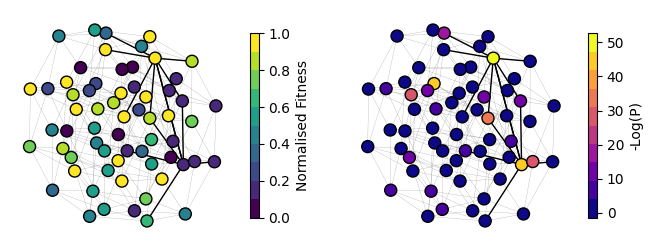

In [27]:
def remove_negative_sign(x, pos):
    return str(x).replace("-", "")

def format_yticks(x, pos):
    return f"{abs(x):.1f}"

dtype_spec = {'Genotype': str}
df = pd.read_csv('../data_files/PTE_catact_2NH.csv', dtype=dtype_spec)
seq_ls = df['Genotype'].tolist()
values = df['F'].tolist()
scaler = MinMaxScaler()
values = [val[0] for val in (scaler.fit_transform(np.array(values).reshape(-1,1)))]

G_h = graph_ruggedness_de.build_ohe_graph(seq_ls=seq_ls,
                                        values=values,
                                        hamming_edges=True)
graph_ruggedness_de.compute_local_dirichlet_energy(G=G_h)

G_k = graph_ruggedness_de.build_ohe_graph(seq_ls=seq_ls,
                                        values=values,
                                        hamming_edges=False)
graph_ruggedness_de.compute_local_dirichlet_energy(G=G_k)
local_logp_dict = brownian_motion.sample_prior_dist(G=G_k,
                                                    sample_size=0.5,
                                                    ruggedness_fn=graph_ruggedness_de.compute_dirichlet_energy,
                                                    local=True)

#Update nodes with -logP value. 
for node, data in G_k.nodes(data=True):
    # Compute the -logP value for the current node
    logp_value = -brownian_motion.compute_log_probability(
        prior_arr=local_logp_dict[node], 
        empirical_val=data['local_dirichlet']
    )
    
    # Update the node with the 'logp' attribute
    G_k.nodes[node]['logp'] = logp_value

#pos=nx.fruchterman_reingold_layout(G_h)

fig = plt.figure(figsize=(8, 3))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], figure=fig)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

# For the first graph
values = [node[1]['value'] for node in G_k.nodes(data=True)]
min_val, max_val = min(values), max(values)
viridis = plt.cm.get_cmap('viridis', 10)
norm = colors.Normalize(vmin=min_val, vmax=max_val)
node_colors = [viridis(norm(value)) for value in values]
sm = cm.ScalarMappable(cmap=viridis, norm=norm)
sm.set_array([])
nx.draw(G_k, pos=pos, ax=ax1, node_color=node_colors, with_labels=False, edgecolors='black', node_size=75, width=0.15, edge_color='grey')
fig.colorbar(sm, ax=ax1, orientation='vertical', shrink=0.8, label='Normalised Fitness')

# Define the nodes for which you want to highlight connected edges
nodes_to_highlight = ["100000", "110100"]

# Find edges connected to these nodes
edges_to_highlight = []
for node in nodes_to_highlight:
    if node in G_k:
        edges_to_highlight.extend(list(G_k.edges(node)))

# Highlight the connected edges in black
nx.draw_networkx_edges(G_k, pos, ax=ax1, edgelist=edges_to_highlight, edge_color='black', width=1)

# For the second graph
values = [node[1]['logp'] for node in G_k.nodes(data=True)]
min_val, max_val = min(values), max(values)
plasma = plt.cm.get_cmap('plasma', 10)
norm = colors.Normalize(vmin=min_val, vmax=max_val)
node_colors = [plasma(norm(value)) for value in values]
sm = cm.ScalarMappable(cmap=plasma, norm=norm)
sm.set_array([])
nx.draw(G_k, pos=pos, ax=ax2, node_color=node_colors, with_labels=False, edgecolors='black', node_size=75, width=0.15, edge_color='grey')
fig.colorbar(sm, ax=ax2, orientation='vertical', shrink=0.8, label='-Log(P)')

# Find edges connected to these nodes
edges_to_highlight = []
for node in nodes_to_highlight:
    if node in G_k:
        edges_to_highlight.extend(list(G_k.edges(node)))

# Highlight the connected edges in black
nx.draw_networkx_edges(G_k, pos, ax=ax2, edgelist=edges_to_highlight, edge_color='black', width=1, node_size=0)

plt.savefig('figures/Figure_3/PTE_2NH_knn.pdf')
plt.show()